Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.


# SPADE VAE-GAN

In this tutorial, we apply SPADE, a VAE-GAN-based neural network developed by Park et al. [1] that performs semantic image synthesis. We apply to a subset of BraTS [2] that we registered to MNI space and resampled to 2mm isotropic space. Segmentations of cerebrospinal fluid, grey and white matter, deep grey matter and brainstem were obtained using Geodesic Information Flows (GIF) [3].

[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

[3] Cardoso, M. J., Wolz, R., Modat, M., Fox, N. C., Rueckert, D., & Ourselin, S. (2012). Geodesic information flows. Medical Image Computing and Computer-Assisted Intervention : MICCAI ...  International Conference on Medical Image Computing and Computer-Assisted Intervention, 15(Pt 2), 262–270. https://doi.org/10.1007/978-3-642-33418-4_33

## Setup environment 

In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib
#!python -c "import gdown" || pip install -q gdown
#%matplotlib inline


####!pip install monai==1.4.0
####!pip install lpips
####!pip install nibabel
####!pip install 'monai[all]'

## Setup imports

In [2]:
import os
import tempfile
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import gdown
import monai
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from monai.networks.nets import SPADENet, MultiScalePatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss

print_config()

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-03-25 13:48:25.350174: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 13:48:25.387656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 13:48:25.387674: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT fa

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: 2.14.1
gdown version: 5.2.0
TorchVision version: 0.18.1+cu118
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.40.2
mlflow version: 2.21.0
pynrrd version: 1.1.3
clearml version: 1.18.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set-up a data directory

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
root_dir = '../'
print("Temporary directory used: %s " % root_dir)

Temporary directory used: ../ 


## Set deterministic training for reproducibility

In [6]:
set_determinism(42)

## Description of data and download dataset

### Description of the data

The data for this notebook comes from the brain tumour segmentation challenge (BraTS) [2]. The images have been registered to MNI space using ANTsPy, and then subsampled to 2mm isotropic resolution. Geodesic Information Flows (GIF) [3] has been used to segment 5 regions: cerebrospinal fluid (CSF), grey matter (GM), white matter (WM), deep grey matter (DGM) and brainstem. Tumour sub-layers were delineated manually as part of the challenge source data. 
In this subset, we have only used one MRI modality , T1. 
Segmentations in this subset are merged and consist of the following labels: 0 (background), 1 (CSF), 2 (GM), 3 (WM), 4 (DGM), 5 (brainstem), 6 (brainstem), 7 (non GD-enahncing tumour core), 8 (peritumoural oedema), 9 (GD-enhancing tumour).

### Download data

In [7]:
# Comment if already downloaded!
#gdown.download("https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m", os.path.join(root_dir, "data.zip"))
#!gdown -O data.zip "https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m" --remaining-ok

We extract and reorganise the data into the relevant sub-folders:

In [8]:
from pathlib import Path
import zipfile

root_dir = Path(root_dir)  # Convert the root directory string to a Path object
zip_obj = zipfile.ZipFile(root_dir / "data.zip", "r")
zip_obj.extractall(root_dir)
images_t1 = root_dir / "BRATS_SUBS2_SUBSET" / "T1"
labels = root_dir / "BRATS_SUBS2_SUBSET" / "Parcellations"


## Prepare dataloaders

In [9]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 4
num_workers = 8
max_epochs = 100
lambda_perc = 1.0
lambda_feat = 0.1
lambda_kld = 0.00001
loss_adv = 1.0

In [10]:
# We create the data dictionaries that we need
all_images = [os.path.join(images_t1, i) for i in os.listdir(images_t1)]
np.random.shuffle(all_images)
corresponding_labels = [
    os.path.join(labels, i.split("/")[-1].replace(i.split("/")[-1].split("_")[0], "Parcellation")) for i in all_images
]
input_dict = [{"image": i, "label": corresponding_labels[ind]} for ind, i in enumerate(all_images)]
input_dict_train = input_dict[: int(len(input_dict) * 0.9)]
input_dict_val = input_dict[int(len(input_dict) * 0.9) :]

We define the relevant transforms:
1. `LoadImaged`: to load the nii tumour images and labels
2. `EnsureChannelFirstd`: to make sure that a channel dimension is added on the tensors
3. `CenterSpatialCropd`: we ensure that the image and labels have the same shape
4. `RandSpatialCropd`: because we are extracting 2D slices from 3D volumes, we crop slices
5. `SqueezeDimd`: we remove the 1-dimension of the slice
6. `Resized`: to bring the shape of all images to the same value
7. `NormalizeIntensityd`: normalise the images
8. `RandBiasFieldd`: bias field augmentation
9. `RandAdjustContrastd`: random contrast augmentation
10. `RandGaussianNoised`: random noise tradition
11. `RandAffined`: random affine augmentation

In [11]:
preliminar_shape = input_shape + [50]  # We take random slices fron the center of the brain
crop_shape = input_shape + [1]
base_transforms = [
    monai.transforms.LoadImaged(keys=["label", "image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.CenterSpatialCropd(keys=["label", "image"], roi_size=preliminar_shape),
    monai.transforms.RandSpatialCropd(keys=["label", "image"], roi_size=crop_shape, max_roi_size=crop_shape),
    monai.transforms.SqueezeDimd(keys=["label", "image"], dim=-1),
    monai.transforms.Resized(keys=["label", "image"], spatial_size=input_shape),
]
last_transforms = [
    monai.transforms.NormalizeIntensityd(keys=["image"]),
    monai.transforms.ToTensord(keys=["image", "label"]),
]

aug_transforms = [
    monai.transforms.RandBiasFieldd(coeff_range=(0, 0.005), prob=0.33, keys=["image"]),
    monai.transforms.RandAdjustContrastd(gamma=(0.9, 1.15), prob=0.33, keys=["image"]),
    monai.transforms.RandGaussianNoised(prob=0.33, mean=0.0, std=np.random.uniform(0.005, 0.015), keys=["image"]),
    monai.transforms.RandAffined(
        rotate_range=[-0.05, 0.05],
        shear_range=[0.001, 0.05],
        scale_range=[0, 0.05],
        padding_mode="zeros",
        mode="nearest",
        prob=0.33,
        keys=["label", "image"],
    ),
]

train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

We create the dataset and dataloader:

In [12]:
train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

We do a sanity check and plot an element of the dataset:

In [13]:
#!pip install --upgrade monai nibabel

torch.Size([4, 1, 128, 128])


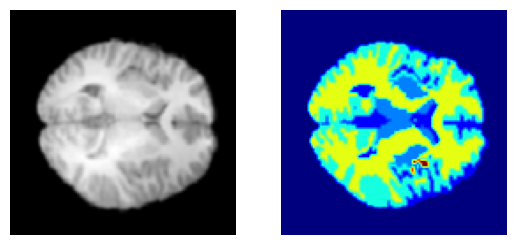

In [14]:
# Sanity check
batch = next(iter(train_loader))
print(batch["image"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, ...], cmap="jet")
plt.axis("off")
plt.show()

### Networks creation and losses

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [17]:
def picture_results(input_label, input_image, output_image):
    plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

We define the KLD loss that we need to ensure that the latent space is Gaussian distributed [4].

[4] Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. CoRR, abs/1312.6.

In [18]:
class KLDLoss(torch.nn.Module):
    """
    Computes the Kullback-Leibler divergence between a normal distribution with mean mu and variance logvar and
     one with mean 0 and variance 1.
    """

    def forward(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

The SPADE paper includes a feature loss which acts like a regulariser of the discriminator. 

In [19]:
def feature_loss(input_features_disc_fake, input_features_disc_real, lambda_feat, device):
    criterion = torch.nn.L1Loss()
    num_d = len(input_features_disc_fake)
    gan_feat_loss = torch.zeros(1).to(device)
    for i in range(num_d):  # for each discriminator
        num_intermediate_outputs = len(input_features_disc_fake[i])
        for j in range(num_intermediate_outputs):  # for each layer output
            unweighted_loss = criterion(input_features_disc_fake[i][j], input_features_disc_real[i][j].detach())
            gan_feat_loss += unweighted_loss * lambda_feat / num_d
    return gan_feat_loss

SPADE can be used as a GAN, for which only a decoder is necessary, or a VAE-GAN, which includes an image ("style") encoder. The decoder incorporates special normalisation blocks called "SPADE" blocks. They take the semantic map and obtain rich features to normalise the activations per semantic layer.

In [20]:
net = SPADENet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    label_nc=10,
    input_shape=input_shape,
    channels=[16, 32, 64],
    z_dim=8,
    is_vae=True,
)

SPADE is trained as a GAN network, and therefore, requires a discriminator. In Park's paper, a multi-scale patch-GAN discriminator is used.

In [21]:
discriminator = MultiScalePatchDiscriminator(
    num_d=2,
    num_layers_d=3,
    spatial_dims=2,
    channels=8,
    in_channels=11,
    out_channels=11,
    minimum_size_im=128,
    norm="INSTANCE",
    kernel_size=3,
)

adversarial_loss = PatchAdversarialLoss(reduction="sum", criterion="hinge")

Like in the paper, we also define a perceptual loss:

In [22]:
#!pip install lpips
!nvidia-smi
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="vgg", is_fake_3d=False, pretrained=True)
perceptual_loss = perceptual_loss.to(device)

Tue Mar 25 13:48:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:3B:00.0 Off |                    0 |
| N/A   45C    P0             26W /   70W |    1115MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


In [25]:
kld_loss = KLDLoss()

In [26]:
optimizer_g = torch.optim.Adam(net.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0004)

## Training the network

We train the network on the following loss: a KLD loss to normalise the latent space, the adversarial multi-scale patch-GAN loss, the regularising feature loss and the perceptual loss. The training parameters have to be defined in the following box:

Epoch 0/100
Train: kld: 570.162576 ;perceptual: 3.514935 ;generator: 12.053376 ;feature: 0.135298 ;discriminator: 1.996938 


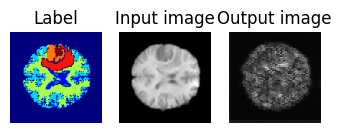

Validation: kld: 270.308563 ;perceptual: 0.461501 ;generator: 2.000780 ;feature: 0.121381;discriminator: 3.987681 
Epoch 10/100
Train: kld: 684.090149 ;perceptual: 2.011028 ;generator: 15.770943 ;feature: 0.212090 ;discriminator: 1.281267 


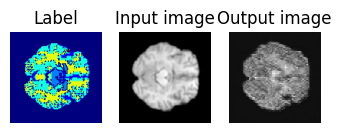

Validation: kld: 97.228882 ;perceptual: 0.312110 ;generator: 2.626986 ;feature: 0.207355;discriminator: 2.608844 
Epoch 20/100
Train: kld: 389.367428 ;perceptual: 2.193864 ;generator: 17.889855 ;feature: 0.210968 ;discriminator: 0.962290 


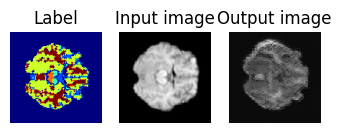

Validation: kld: 29.948219 ;perceptual: 0.404929 ;generator: 2.976907 ;feature: 0.213156;discriminator: 1.900738 
Epoch 30/100
Train: kld: 2166.385712 ;perceptual: 1.912623 ;generator: 18.223878 ;feature: 0.211442 ;discriminator: 0.765642 


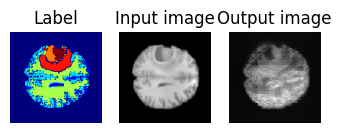

Validation: kld: 365.091309 ;perceptual: 0.338675 ;generator: 3.187131 ;feature: 0.208614;discriminator: 1.536826 
Epoch 40/100
Train: kld: 2316.013367 ;perceptual: 1.987937 ;generator: 10.706758 ;feature: 0.093652 ;discriminator: 1.473455 


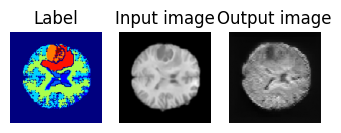

Validation: kld: 554.862244 ;perceptual: 0.325599 ;generator: 1.784362 ;feature: 0.088385;discriminator: 2.871129 
Epoch 50/100
Train: kld: 1547.653015 ;perceptual: 1.965760 ;generator: 16.350188 ;feature: 0.116812 ;discriminator: 1.445050 


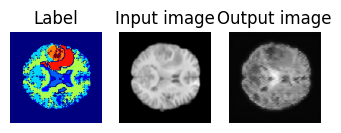

Validation: kld: 207.237274 ;perceptual: 0.293558 ;generator: 2.723104 ;feature: 0.129187;discriminator: 2.751424 
Epoch 60/100
Train: kld: 1322.058411 ;perceptual: 2.094049 ;generator: 15.525936 ;feature: 0.152061 ;discriminator: 1.100861 


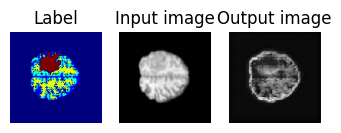

Validation: kld: 255.788254 ;perceptual: 0.330923 ;generator: 2.839783 ;feature: 0.187277;discriminator: 2.057214 
Epoch 70/100
Train: kld: 2426.282455 ;perceptual: 2.022823 ;generator: 17.249877 ;feature: 0.143268 ;discriminator: 0.880960 


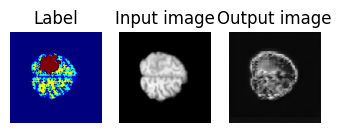

Validation: kld: 366.695374 ;perceptual: 0.296279 ;generator: 3.101545 ;feature: 0.147820;discriminator: 1.702310 
Epoch 80/100
Train: kld: 8187.360596 ;perceptual: 1.924534 ;generator: 14.620272 ;feature: 0.157772 ;discriminator: 1.008735 


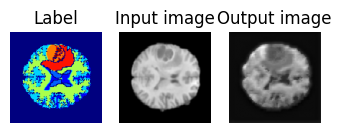

Validation: kld: 1116.910767 ;perceptual: 0.327188 ;generator: 3.208777 ;feature: 0.189283;discriminator: 1.867190 
Epoch 90/100
Train: kld: 2635.618317 ;perceptual: 1.967667 ;generator: 17.520881 ;feature: 0.189940 ;discriminator: 0.764958 


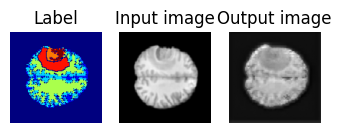

Validation: kld: 461.819641 ;perceptual: 0.306089 ;generator: 2.973299 ;feature: 0.175279;discriminator: 1.655771 


In [27]:
net = net.to(device)
discriminator = discriminator.to(device)
torch.autograd.set_detect_anomaly(True)
losses = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
losses_val = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
for epoch in range(max_epochs):
    if epoch % 10 == 0:
        print("Epoch %d/%d" % (epoch, max_epochs))
    losses_epoch = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for d in train_loader:
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 10).to(device)
        optimizer_g.zero_grad()

        # Losses gen
        out, mu, logvar = net(label, image)
        kld_ = kld_loss(mu, logvar)
        disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
        loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
        disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
        loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
        loss_perc = perceptual_loss(out, target=image)
        total_loss = loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
        total_loss.backward(retain_graph=True)
        optimizer_g.step()

        # Store
        losses_epoch["kld"] += kld_.item()
        losses_epoch["perceptual"] += loss_perc.item()
        losses_epoch["generator"] += loss_g.item()
        # Train disc
        out, _, _ = net(label, image)
        disc_fakes, _ = discriminator(torch.cat([out, label], 1))
        loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
        loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
        optimizer_d.zero_grad()
        loss_d = loss_d_r + loss_g_f
        loss_d.backward()
        optimizer_d.step()

        # Store
        losses_epoch["feature"] = loss_feat.item()
        losses_epoch["discriminator"] = (loss_d_r.item() + loss_g_f.item()) / 2

    if epoch % 10 == 0:
        msgs = [
            f"Train: kld: {np.mean(losses_epoch['kld']):4f} ",
            f"perceptual: {np.mean(losses_epoch['perceptual']):4f} ",
            f"generator: {np.mean(losses_epoch['generator']):4f} ",
            f"feature: {np.mean(losses_epoch['feature']):4f} ",
            f"discriminator: {np.mean(losses_epoch['discriminator']):4f} ",
        ]
        print(";".join(msgs))

    losses_epoch_val = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for d in val_loader:
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 10).to(device)
            # Losses gen
            out, mu, logvar = net(label, image)
            kld_ = kld_loss(mu, logvar)
            disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
            loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
            disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
            loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
            loss_perc = perceptual_loss(out, target=image)
            total_loss = loss_adv * loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
            # Store
            losses_epoch_val["kld"] += kld_.item()
            losses_epoch_val["perceptual"] += loss_perc.item()
            losses_epoch_val["generator"] += loss_g.item()
            # Train disc
            out, _, _ = net(label, image)
            disc_fakes, _ = discriminator(torch.cat([out, label], 1))
            loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
            loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
            loss_d = loss_adv * (loss_d_r + loss_g_f)

            # Store
            losses_epoch_val["feature"] = loss_feat.item()
            losses_epoch_val["discriminator"] = loss_d_r.item() + loss_g_f.item()

    if epoch % 10 == 0:
        picture_results(label, image, out)
        msgs = [
            f"Validation: kld: {np.mean(losses_epoch_val['kld']):4f} ",
            f"perceptual: {np.mean(losses_epoch_val['perceptual']):4f} ",
            f"generator: {np.mean(losses_epoch_val['generator']):4f} ",
            f"feature: {np.mean(losses_epoch_val['feature']):4f}",
            f"discriminator: {np.mean(losses_epoch_val['discriminator']):4f} ",
        ]
        print(";".join(msgs))

    for key, val in losses_epoch.items():
        losses[key].append(val / len(train_loader))
    for key, val in losses_epoch_val.items():
        losses_val[key].append(val / len(val_loader))